## Homework 9

In this homework, we'll deploy the dogs vs cats model we trained in the previous 
homework.

Download the model from here: 

https://github.com/alexeygrigorev/large-datasets/releases/download/dogs-cats-model/dogs_cats_10_0.687.h5

In [ ]:
!wget --directory-prefix=models/ https://github.com/alexeygrigorev/large-datasets/releases/download/dogs-cats-model/dogs_cats_10_0.687.h5

### Question 1

Now convert this model from Keras to TF-Lite format.

What's the size of the converted model? import tensorflow as tf

In [ ]:
!pip install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

In [3]:
MODEL_DIR = 'models'
MODEL_NAME = 'dogs_cats_10_0.687'

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
#import tensorflow.lite as tflite
import tflite_runtime.interpreter as tflite

In [5]:
model = keras.models.load_model(os.path.join(MODEL_DIR, MODEL_NAME + '.h5'))
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open(os.path.join(MODEL_DIR, MODEL_NAME + '.tflite'), 'wb') as f_out:
    f_out.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\TIMUR~1.KAM\AppData\Local\Temp\tmprhnaja_v\assets


In [6]:
ls models

 ’®¬ ў гбва®©бвўҐ C ­Ґ Ё¬ҐҐв ¬ҐвЄЁ.
 ‘ҐаЁ©­л© ­®¬Ґа в®¬ : 581C-CCA8

 ‘®¤Ґа¦Ё¬®Ґ Ї ЇЄЁ C:\Users\Timur.Kamaliev\Documents\Python Scripts\ML_Zoomcamp\Homeworks\Homework #9\models

29.11.2021  09:25    <DIR>          .
29.11.2021  09:25    <DIR>          ..
25.11.2021  10:02        89я758я304 dogs_cats_10_0.687.h5
29.11.2021  09:25        44я865я868 dogs_cats_10_0.687.tflite
               2 д ©«®ў    134я624я172 Ў ©в
               2 Ї Ї®Є  124я587я880я448 Ў ©в бў®Ў®¤­®


The closest answer is 43 Mb.

### Question 2

To be able to use this model, we need to know the index of the input and 
the index of the output. 

What's the output index for this model? 

In [7]:
interpreter = tflite.Interpreter(model_path=os.path.join(MODEL_DIR, MODEL_NAME + '.tflite'))
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

In [8]:
print(f'Output index for this model is {output_index}.')

Output index for this model is 13.


### Preparing the image

You'll need some code for downloading and resizing images. You can use 
this code:

```python
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img
```

For that, you'll need to have pillow installed:

```bash
pip install pillow
```

Let's download and resize this image: 

https://upload.wikimedia.org/wikipedia/commons/9/9a/Pug_600.jpg

Based on [the solution of the previous homework](https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/08-deep-learning/CNN_solution.ipynb),
what should be the target size for the image?


In [9]:
from io import BytesIO
from urllib import request
from PIL import Image

In [10]:
def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img

def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

The target size for the image should be (150, 150).

In [11]:
from tensorflow.keras.preprocessing import image

In [12]:
IMAGE_PATH = 'https://upload.wikimedia.org/wikipedia/commons/9/9a/Pug_600.jpg'

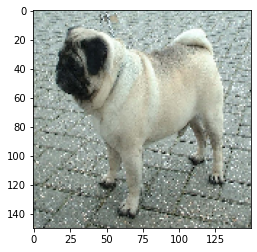

In [13]:
img = download_image(IMAGE_PATH)
img = prepare_image(img, target_size=(150, 150))
plt.imshow(img);

### Question 3

Now we need to turn the image into an numpy array and pre-process it. 

> Tip: Check the previous homework. What was the pre-processing 
> we did there?

After the pre-processing, what's the value in the first pixel, the R channel?

In [14]:
def preprocess_input(x):
    x /= 255
    return x

In [15]:
x = np.array(img, dtype='float32')
X = np.array([x])
X = preprocess_input(X)
print(f'The R channel value in the first pixel is {X[0][0][0][0]}.')

The R channel value in the first pixel is 0.7058823704719543.


### Question 4

Now let's apply this model to this image. What's the output of the model?

In [16]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)
print(f'Model output: {preds[0][0]}.')

Model output: 0.7704913020133972.


### Prepepare the lambda code

Now you need to copy all the code into a separate python file. You will 
need to use this file for the next two questions.

Tip: you can test this file locally with `ipython` or Jupyter Notebook 
by importing the file and invoking the function from this file.  

### Docker 

For the next two questions, we'll use a Docker image that I already 
prepared. This is the Dockerfile that I used for creating the image:

```docker
FROM public.ecr.aws/lambda/python:3.8
COPY cats-dogs-v2.tflite .
```

And pushed it to [`agrigorev/zoomcamp-cats-dogs-lambda:v2`](https://hub.docker.com/r/agrigorev/zoomcamp-cats-dogs-lambda/tags).


> Note: The image already contains a model and it's not the same model
> as the one we used for questions 1-4.

### Question 5

Now let's extend this docker image, install all the required libraries
and add the code for lambda.

You don't need to include the model in the image. It's already included. 
The name of the file with the model is `cats-dogs-v2.tflite` and it's 
in the current workdir in the image (see the Dockerfile above for the 
reference).


What's the image id of the base image? 

In the build logs (on Linux), you'll see a log like that:

```
$ docker some-command-for-building
Sending build context to Docker daemon  2.048kB
Step 1/N : FROM agrigorev/zoomcamp-cats-dogs-lambda:v2
 ---> XXXXXXXXXXXX
Step 2/N : ....
```

You need to get this `XXXXXXXXXXXX`. 

On MacOS and Windows, the logs for `docker build` are different. 
To get the image id there, you can use `docker image ls -a`.

`DIGEST NUMBER`: `101693c6a156`, `Image ID`: `322fc756f258`

### Question 6

Now run the container locally.

Score this image: https://upload.wikimedia.org/wikipedia/commons/1/18/Vombatus_ursinus_-Maria_Island_National_Park.jpg

What's the output from the model? 

Model output is 0.5413472652435303.